In [1]:
from ica_benchmark.io.load import load_gdf_file
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from ica_benchmark.processing.feature import tfr_multitaper, psd_multitaper

In [2]:
filepath = "/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/A01T.gdf"

In [3]:
gdf_data, labels, ch_names, info = load_gdf_file(filepath)

Extracting EDF parameters from /home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/paulo/Documents/GIT/BCI_MsC/ica_benchmark/io/load.py:26: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  gdf_data = read_raw_gdf(filepath, preload=PRELOAD)
/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/paulo/Documents/GIT/BCI_MsC/ica_benchmark/io/load.py:30: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  gdf_data = read_raw_gdf(


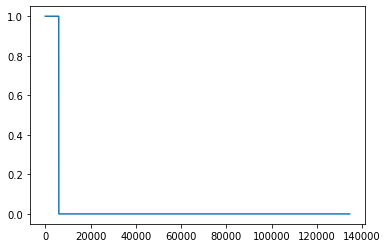

In [4]:
label1 = labels[::5, 0]
plt.plot(label1)

In [5]:
from mne.io import read_raw_gdf
from mne import Epochs, events_from_annotations

In [6]:
gdf = read_raw_gdf(
    filepath,
    eog=["EOG-left", "EOG-central", "EOG-right"],
    exclude=["EOG-left", "EOG-central", "EOG-right"]
)
events = events_from_annotations(gdf, event_id={"769": 0, "770": 1, "771": 2, "772": 3})
epochs = Epochs(gdf, events[0], event_repeated="drop", reject_by_annotation=True, tmin=-.3, tmax=.7, reject=dict(eeg=1e-4))
epochs.drop_bad()
events = epochs.events
print(events.shape)

Extracting EDF parameters from /home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
Not setting metadata
288 matching events found
Setting baseline interval to [-0.3, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 288 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['EEG-Fz', 'EEG-0', 'EEG-2']
    Rejecting  epoch based on EEG : ['EEG-0', 'EEG-1', 'EEG-2', 'EEG-4', 'EEG-Cz', 'EEG-C4', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16']
    Rejecting  epoch based on EEG : ['EEG-Fz']
    Rejecting  epoch based on EEG : ['EEG-5']


/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
<ipython-input-6-741568cd4f42>:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  gdf = read_raw_gdf(


    Rejecting  epoch based on EEG : ['EEG-Fz']
    Rejecting  epoch based on EEG : ['EEG-Fz']
6 bad epochs dropped
(282, 3)


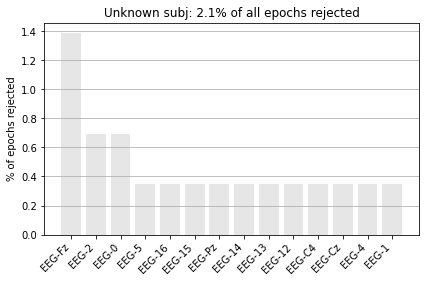

In [7]:
epochs.plot_drop_log();

In [8]:
epochs.get_data().shape

Loading data for 282 events and 251 original time points ...


(282, 22, 251)

In [9]:
from sklearn.model_selection import train_test_split
from mne.time_frequency import psd_multitaper
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP

In [10]:
from ica_benchmark.processing.ica import CustomICA, get_all_methods, get_ica_instance
from time import time
from ica_benchmark.scoring import apply_pairwise, SCORING_FN_DICT

csp = CSP(n_components=10, transform_into="average_power")
scaler = StandardScaler()

methods = get_all_methods()
for method in methods:
    print("\nRunning method '{}'.".format(method), end=None)
    start = time()
    ica = get_ica_instance(method=method)
    ica.fit(epochs)
    fit_time = time()
    sources_epochs = ica.get_sources(epochs)
    
    reshaped = np.hstack(sources_epochs.get_data())
    print("\tICA fit Duration: {:.2f}s\n".format(fit_time - start))
    
    for scoring_name, scoring_fn in SCORING_FN_DICT.items():
        
        score_start = time()
        score = apply_pairwise(reshaped.T, scoring_fn)

        print("\tAvg. {}: {:.3f} in {:.2f}s".format(scoring_name, score, time() - score_start))
    
    try:
        train_start = time()
        x, y = sources_epochs.get_data(), events[:, 2]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)
        csp.fit(x_train, y_train)
        x_train, x_test = csp.transform(x_train), csp.transform(x_test)
        x_train, x_test = np.nan_to_num(x_train, posinf=0., neginf=0.), np.nan_to_num(x_test, posinf=0., neginf=0.)
        x_train, x_test = scaler.fit_transform(x_train), scaler.transform(x_test)
        clf = SVC(C=4.)
        clf.fit(x_train, y_train)
        pred = clf.predict(x_test)
        acc, kappa = balanced_accuracy_score(y_test, pred), cohen_kappa_score(y_test, pred)
    except Exception as e:
        print("\t", str(e))
        acc, kappa = 0., 0.
    print("\tClassification ACC/KAPPA: {:.1f}% / {:.1f}% in {:.2f}s".format(acc * 100, kappa * 100, time() - train_start))


Running method 'fastica'.
	ICA fit Duration: 3.59s

	Avg. coherence: 31.269 in 1.68s
	Avg. correntropy_05: 0.281 in 0.15s
	Avg. correntropy_1: 0.238 in 0.18s
	Avg. correntropy_2: 0.165 in 0.20s
	Avg. mutual_informatio: 0.050 in 2.04s
	Classification ACC/KAPPA: 30.8% / 7.5% in 0.45s

Running method 'infomax'.
	ICA fit Duration: 11.10s

	Avg. coherence: 31.282 in 2.04s
	Avg. correntropy_05: 0.163 in 0.25s
	Avg. correntropy_1: 0.153 in 0.21s
	Avg. correntropy_2: 0.127 in 0.20s
	Avg. mutual_informatio: 0.051 in 1.91s
	Classification ACC/KAPPA: 30.3% / 8.4% in 0.38s

Running method 'picard'.
	ICA fit Duration: 5.61s

	Avg. coherence: 31.281 in 1.71s
	Avg. correntropy_05: 0.282 in 0.15s
	Avg. correntropy_1: 0.239 in 0.16s
	Avg. correntropy_2: 0.165 in 0.16s
	Avg. mutual_informatio: 0.048 in 2.06s
	Classification ACC/KAPPA: 27.1% / 4.2% in 0.64s

Running method 'ext_infomax'.
	ICA fit Duration: 14.86s

	Avg. coherence: 31.270 in 2.05s
	Avg. correntropy_05: 0.335 in 0.20s
	Avg. correntropy_1:

/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/decoding/csp.py:645: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/decoding/csp.py:647: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


	 array must not contain infs or NaNs
	Classification ACC/KAPPA: 0.0% / 0.0% in 0.49s

Running method 'choi_var'.
	ICA fit Duration: 0.70s

	Avg. coherence: 31.276 in 1.86s
	Avg. correntropy_05: 0.279 in 0.20s
	Avg. correntropy_1: 0.237 in 0.21s
	Avg. correntropy_2: 0.164 in 0.20s
	Avg. mutual_informatio: 0.055 in 2.10s
	Classification ACC/KAPPA: 26.9% / 2.8% in 0.42s

Running method 'choi_vartd'.
	ICA fit Duration: 0.99s

	Avg. coherence: 31.461 in 1.75s
	Avg. correntropy_05: 0.385 in 0.17s
	Avg. correntropy_1: 0.267 in 0.21s
	Avg. correntropy_2: 0.169 in 0.20s
	Avg. mutual_informatio: 1.728 in 1.93s


/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/decoding/csp.py:645: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/decoding/csp.py:647: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


	 array must not contain infs or NaNs
	Classification ACC/KAPPA: 0.0% / 0.0% in 0.64s

Running method 'choi_td'.
	ICA fit Duration: 1.05s

	Avg. coherence: 31.469 in 1.76s
	Avg. correntropy_05: 0.348 in 0.16s
	Avg. correntropy_1: 0.253 in 0.17s
	Avg. correntropy_2: 0.166 in 0.16s
	Avg. mutual_informatio: 1.568 in 2.05s


/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/decoding/csp.py:645: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/decoding/csp.py:647: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


	 array must not contain infs or NaNs
	Classification ACC/KAPPA: 0.0% / 0.0% in 0.60s

Running method 'coro'.
	ICA fit Duration: 1.58s

	Avg. coherence: 31.740 in 1.75s
	Avg. correntropy_05: 0.475 in 0.20s
	Avg. correntropy_1: 0.285 in 0.20s
	Avg. correntropy_2: 0.170 in 0.20s
	Avg. mutual_informatio: 3.942 in 1.88s


/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/decoding/csp.py:645: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/paulo/anaconda3/envs/bci/lib/python3.8/site-packages/mne/decoding/csp.py:647: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


	 array must not contain infs or NaNs
	Classification ACC/KAPPA: 0.0% / 0.0% in 0.48s

Running method 'jade'.
	ICA fit Duration: 4.79s

	Avg. coherence: 31.283 in 1.76s
	Avg. correntropy_05: 0.299 in 0.18s
	Avg. correntropy_1: 0.245 in 0.20s
	Avg. correntropy_2: 0.166 in 0.20s
	Avg. mutual_informatio: 0.048 in 2.03s
	Classification ACC/KAPPA: 39.2% / 17.0% in 0.44s
